In [8]:
#rdkit関連のimport
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools

#その他のimport
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

datasets = pd.read_csv("../AmesCalculation/test/TestAmes_100samples.csv")

#データの規格化
def rescaling(features):
    norm_features = []
    max_value = max(features)
    min_value = min(features)
    for feature in features:
        norm_feature = (feature - min_value)/(max_value - min_value)
        norm_features.append(norm_feature)
    
    return norm_features
norm_datasets = datasets.loc[:,['ID','smiles','activity']]
columns = datasets.columns
for column in columns[3:]:
    norm_datasets[column] = rescaling(datasets[column])

PandasTools.AddMoleculeColumnToFrame(frame=norm_datasets, smilesCol = 'smiles')

#フィンガープリントを準備
maccskeys = []
for mol in norm_datasets.ROMol:
    mol = Chem.AddHs(mol) 
    maccskey = [float(x) for x in AllChem.GetMACCSKeysFingerprint(mol)]
    maccskeys.append(maccskey)

calc_datasets = norm_datasets.iloc[:,3:-1]
maccskeys_df = pd.DataFrame(maccskeys)
calc_sets = pd.concat([calc_datasets,maccskeys_df], axis=1)

In [10]:
#無制限の決定木
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(maccskeys_df, norm_datasets.activity, random_state= 0)
xcalc_train, xcalc_test, ycalc_train, ycalc_test = train_test_split(calc_sets, norm_datasets.activity, random_state= 0)

tree = DecisionTreeClassifier(random_state= 0)
tree.fit(x_train, y_train)
print("Only Finger Print")
print('accuracy on train set: {:.3f}'.format(tree.score(x_train, y_train)))
print('accuracy on test set: {:.3f}'.format(tree.score(x_test, y_test)))

calc_tree = DecisionTreeClassifier(random_state= 0)
calc_tree.fit(xcalc_train, ycalc_train)
print("Calculation Datasets")
print('accuracy on train set: {:.3f}'.format(calc_tree.score(xcalc_train, ycalc_train)))
print('accuracy on test set: {:.3f}'.format(calc_tree.score(xcalc_test, ycalc_test)))

Only Finger Print
accuracy on train set: 1.000
accuracy on test set: 0.440
Calculation Datasets
accuracy on train set: 1.000
accuracy on test set: 0.480


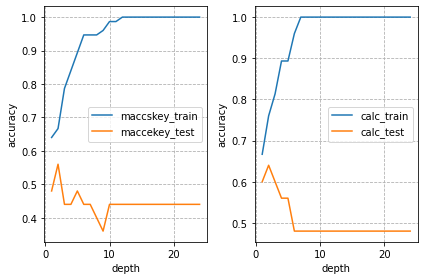

In [11]:
## 決定木の調整
accs_train = []
accs_test = []
accs_calc_train = []
accs_calc_test = []
deep = 25
depth = range(1,deep)
for i in range(1, deep):
    tree2 = DecisionTreeClassifier(max_depth=i, random_state=0)
    tree2.fit(x_train, y_train)
    acc_train = tree2.score(x_train, y_train)
    acc_test = tree2.score(x_test, y_test)
    accs_train.append(acc_train)
    accs_test.append(acc_test)
for j in range(1, deep):
    calc_tree2 = DecisionTreeClassifier(max_depth=j, random_state=0)
    calc_tree2.fit(xcalc_train, ycalc_train)
    acc_calc_train = calc_tree2.score(xcalc_train, ycalc_train)
    acc_calc_test = calc_tree2.score(xcalc_test, ycalc_test)
    accs_calc_train.append(acc_calc_train)
    accs_calc_test.append(acc_calc_test)
    
#graph
fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(depth, accs_train, label = 'maccskey_train')
ax1.plot(depth, accs_test, label = 'maccekey_test')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(depth, accs_calc_train, label = 'calc_train')
ax2.plot(depth, accs_calc_test, label = 'calc_test')

# 軸の一覧取得
axs = plt.gcf().get_axes()

# 軸毎にループ
for ax in axs:
    # 現在の軸を変更
    plt.axes(ax)
    
    # 凡例を表示
    plt.legend(loc=5)

    # グリッド
    plt.grid(linestyle='--')

    # 軸ラベル
    plt.xlabel('depth')
    plt.ylabel('accuracy')
    
plt.tight_layout()
plt.show()

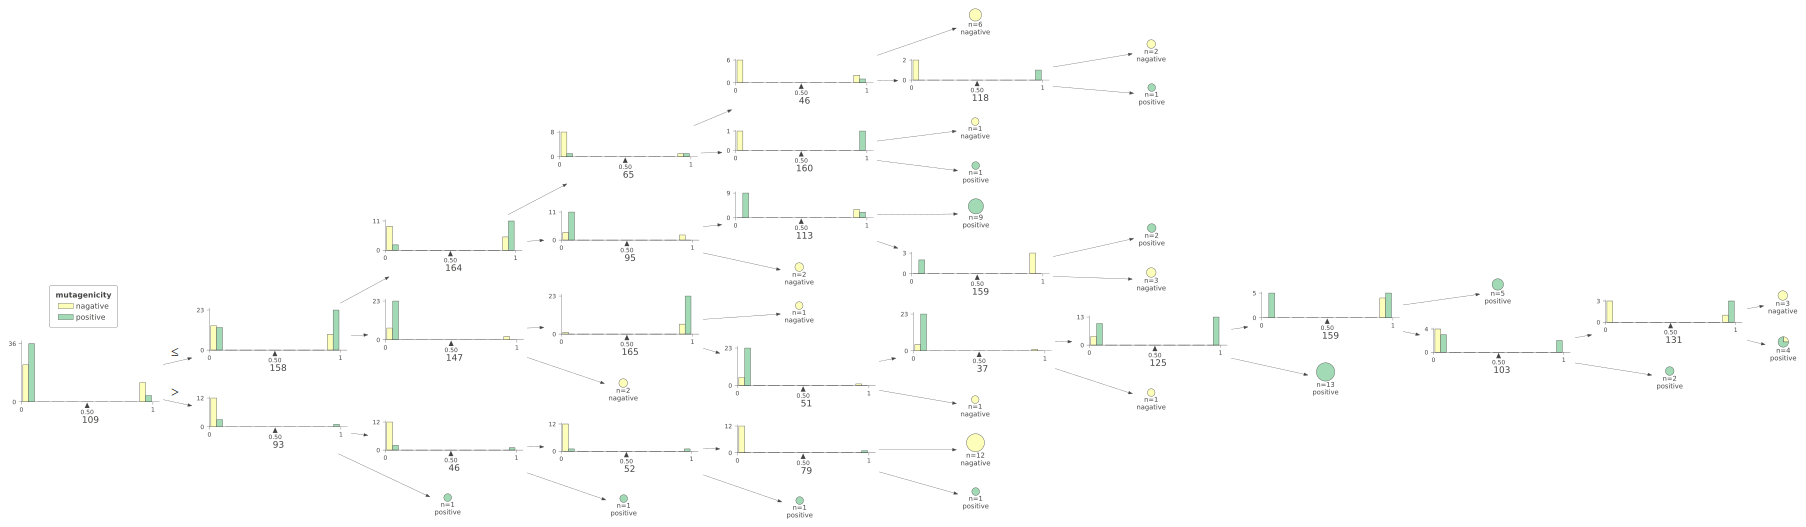

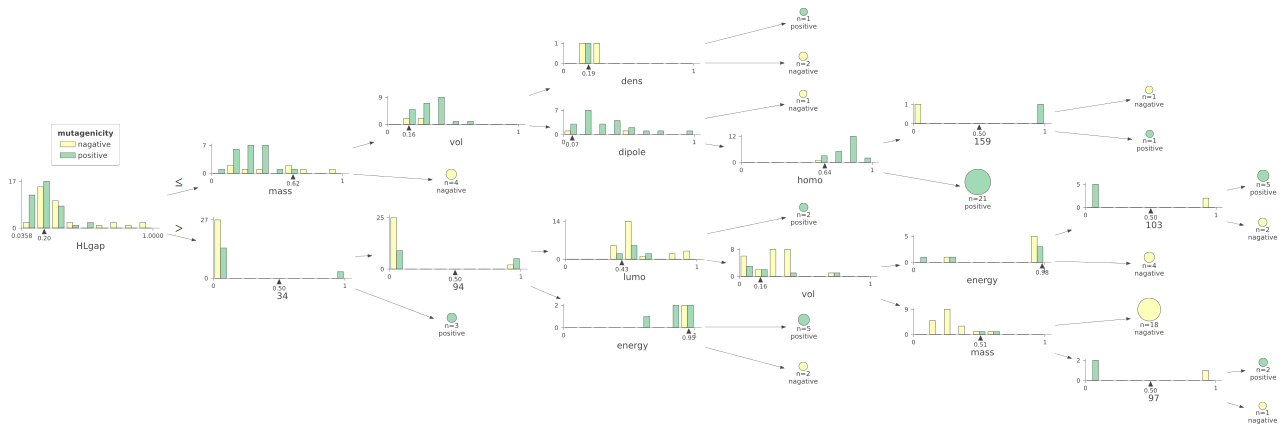

In [12]:
from dtreeviz.trees import dtreeviz

tree_maccskey = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_maccskey.fit(x_train, y_train)
viz_pre  = dtreeviz(tree_maccskey, x_train, y_train, target_name= 'mutagenicity', feature_names=maccskeys_df.columns, class_names=['nagative', 'positive'], orientation='LR', histtype='bar')
display(viz_pre)

tree_calc = DecisionTreeClassifier(max_depth=10, random_state=0)
tree_calc.fit(xcalc_train, ycalc_train)
viz_pre  = dtreeviz(tree_calc, xcalc_train, ycalc_train, target_name= 'mutagenicity', feature_names=calc_sets.columns, class_names=['nagative', 'positive'], orientation='LR', histtype='bar')
display(viz_pre)